## Visualizing One Image, its Outputs, and Accuracy Statistics from the Test Set

In this notebook, we load one image from the test set. We then visualize the image and the ground truth associated with it, run it through a model specified in the parameters, and visualize its outputs. We then run the coco evaluator module to measure the performance of the model on the single test image.

In [1]:
import sys
import os

# specify which CUDA device to use, in case of multiple GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

### Parameters, imports, and functions

Use the below cell to input the experiment name and desired crop size, used for height and width

In [2]:
# parameters, change according to which model is used for visualization

crop = 400
experiment = f'detr_output_400_binary_skip'
output_dir = os.path.join('/workspace/',experiment)
vis_dir = os.path.join('/workspace/',experiment,'val_outputs')
os.makedirs(vis_dir, exist_ok=True)

sys.argv =  ['main.py', '--num_classes', '2', '--coco_path', '/workspace/processed_data_v7/initial_data', '--num_workers', '0', '--resume', f'{output_dir}/best_checkpoint.pth', '--batch_size', '1', '--crop', f'{crop}']

In [3]:
# imports
module_path = os.path.abspath(os.path.join('/workspace/Transformer_OD_TPU'))
if module_path not in sys.path:
    sys.path.append(module_path)

import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import argparse
import datetime
import json
import random
import time
from pathlib import Path
from tqdm import tqdm

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
torch.set_printoptions(sci_mode=False)

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

import main

In [4]:
# functions for visualizing model inputs and outputs

def plot_inputs(sample):
    image = sample[0].tensors[0].cpu().numpy()[0,:,:]
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='Greys_r')
    ax = plt.gca()
    
    input_bbox_rescale = rescale_bboxes(sample[1][0]['boxes'].to(device), image.shape)
    for (xmin, ymin, xmax, ymax) in input_bbox_rescale.tolist():
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='g', linewidth=3))

def plot_outputs(sample, prob, boxes):
    image = sample[0].tensors[0].cpu().numpy()[0,:,:]
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='Greys_r')
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='r', linewidth=3))
        cl = p.argmax()
        text = f'{p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='red', alpha=0.8))
    
    input_bbox_rescale = rescale_bboxes(sample[1][0]['boxes'].to(device), image.shape)
    for (xmin, ymin, xmax, ymax) in input_bbox_rescale.tolist():
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='g', linewidth=3))

def rescale_bboxes(out_bbox, shape):
    w, h = shape
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([w, h, w, h], dtype=torch.float32).to(device)
    return b

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

### Building the dataset, dataloader, model, and evaluator

In [5]:
parser = main.get_args_parser()
args = parser.parse_args()

In [6]:
dataset_test = build_dataset(image_set='test', args=args)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
sampler_test = torch.utils.data.SequentialSampler(dataset_test)
data_loader_test = DataLoader(dataset_test, 1, sampler=sampler_test,
                            drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

In [8]:
device = torch.device(args.device)
model, criterion, postprocessors = build_model(args)
model = model.to(device).eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [10]:
from datasets.coco_eval import CocoEvaluator
base_ds = get_coco_api_from_dataset(dataset_test)

In [11]:
model.eval()
criterion.eval()
metric_logger = utils.MetricLogger(delimiter="  ")
metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
iou_types = tuple(k for k in ('segm', 'bbox') if k in postprocessors.keys())
coco_evaluator = CocoEvaluator(base_ds, iou_types)

('bbox',)


### Retreive one sample from the test loader and visualize the inputs

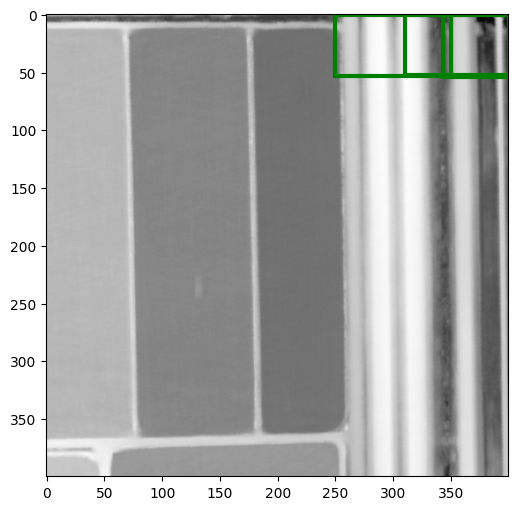

In [12]:
data_loader_iter = iter(data_loader_test)
sample = next(data_loader_iter)

plot_inputs(sample)

### Run the model and visualize outputs, then get accuracy statistics for the single sample

In [13]:
samples, targets = sample
samples = samples.to(device)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
outputs = model(samples)
loss_dict = criterion(outputs, targets)
weight_dict = criterion.weight_dict
loss_dict_reduced = utils.reduce_dict(loss_dict)
loss_dict_reduced_scaled = {k: v * weight_dict[k]
                            for k, v in loss_dict_reduced.items() if k in weight_dict}
loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                              for k, v in loss_dict_reduced.items()}
metric_logger.update(loss=sum(loss_dict_reduced_scaled.values()),
                     **loss_dict_reduced_scaled,
                     **loss_dict_reduced_unscaled)
metric_logger.update(class_error=loss_dict_reduced['class_error'])
orig_target_sizes = torch.stack([t['orig_size'] for t in targets], dim=0)
augmented_target_sizes = torch.stack([t['size'] for t in targets], dim=0)
results = postprocessors['bbox'](outputs, orig_target_sizes, augmented_target_sizes)
if 'segm' in postprocessors.keys():
    target_sizes = torch.stack([t["size"] for t in targets], dim=0)
    results = postprocessors['segm'](results, outputs, orig_target_sizes, target_sizes)
res = {target['image_id'].item(): output for target, output in zip(targets, results)}
if coco_evaluator is not None:
    coco_evaluator.update(res)

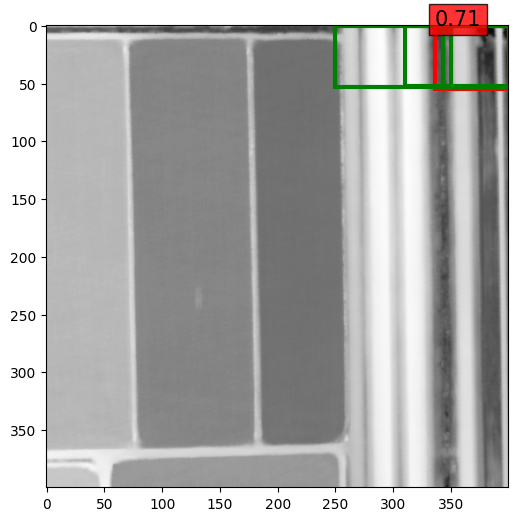

In [14]:
image = sample[0].tensors[0].cpu().numpy()[0,:,:]

probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], image.shape)

plot_outputs(sample, probas[keep], bboxes_scaled)

In [15]:
# accumulate predictions from all images
coco_evaluator.synchronize_between_processes()

if coco_evaluator is not None:
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area